# Russo Andrea - Report
# CQF EXAM 2 - 09/2021 
### Execution time ~ 1 minutes 45 seconds

## Outline of the finance problem and numerical procedure used:

### THE FINANCE ASPECT :

The problem of pricing options through Monte-Carlo simulations is fundamental in finance. Using this method, an option is priced by simulating an elevated number of price paths for the underlying from the starting time to the expiration date of the option contract.\
The payoff for each path is then calculated according to the contract specifications and the expected value of the payoff is computed. \
The resulting cash flow is then discounted back to obtain the price of the option at the starting point in time.

The options considered in this case will be the Asian and the Lookback options.

**Asian** options have a payoff that depends on the average price of the underlying during the time period considered for the contract.\
The values of the underlying can be sampled continuously or discretely and the kind of averaging method employed could be of different types but we will consider arithmetic and geometric averages. \
The payoff for an Asian option is given by the average price minus the strike price, for a call option, and by the strike price minus the average for a put option.\

**Lookback** options allow the holder to exercise the option at the most beneficial price of the underlying asset over the life of the contract.\
The holder receives a cashflow at expiry based on the most advantageous differential between high and low prices during the purchase period, making this a cash-settled option.\
Lookback options can have Fixed or Floating strikes:
- In **FIXED** strike lookback options, the strike is decided at purchase. The payoff is then given by the most beneficial value realised by the price path of the underlying. This will be the highest price for a call option or the lowest for a put option.
- In **FLOATING** strike lookback options, the strike is set automatically at maturity to be the value of the underlying that is most favourable depending on the option being a call or a put. The option will then settle against the market price, calculating the profit or loss against the floating strike.\
In the case of a call, that optimal value is the lowest value achieved by the underlier during the life of the option,
so it pays off the difference between the final value of the underlying asset and that lowest value.\
In the case of a put, the option pays off the difference between the highest value achieved and the value of the underlying asset at the expiration\

### OVERVIEW OF MATHEMATICAL TECHNIQUES:

Different mathematical techniques are employed in order to price the options. In order to simulate the price paths, the Euler-Maruyama scheme will be used. This is a method for approximating numerical solutions to stochastic differential equations. It is an extension of the Euler method used in ODE. The asset price at each time step is computed adding an infinitesimal stochastic increment to the previous value.\
Assuming that the underlying price undergoes a geometric Brownian motion following the SDE $$ dS=\mu Sdt+\sigma SdX_t$$ the Euler-Maruyama scheme determines the price at time $t+dt$ is given by $$ S(t+dt)=S(t) + \mu S(t)dt+\sigma S(t)dX_t $$ Where $dX_t\in\mathcal{N}(0,1)$ is a Gaussian distributed random variable with mean 0 and variance of 1.

Moreover, in the evaluation of Asian options, we also use arithmetic and geometric means.\
Given a set of data $X=\{x_1,x_2,...,x_n\}\in \mathbb{R}$, their arithmetic mean $A$ is given by 
$$ A=\frac{1}{n}\sum_{i=1}^n x_1$$ while their geometric mean is given by $$ G=\left(\prod_{i=1}^n \right)^{\frac{1}{n}}$$

### Asumptions of the program:
For the purpose of this exam, we will assume the following:
- We live in a world where Black-Scholes assumptions hold
- The underlying asset follows a geometric Brownian motion
- The date samples taken for computing averages in the pricing of Asian options and for individuating max/min in lookback options are taken continuously. This means that all the price steps are relevant for their computation. I am aware that this is not what happens in the real market and that sampling is usually taken in discrete intervals (ex: once a week) and that this can affect the pricing of the option. This assumption is taken for simplifying purposes.
- The underlying price changes once a day. This means that given a time to expiry in years, the program will convert that number into days, where the assumption is that a year is composed of 252 days when the markets are open.


# Computations and results :

In [1]:
# Import required libraries

import numpy as np
from numpy import random as rnd

from scipy.stats.mstats import gmean

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize']= 14,7
matplotlib.rcParams['font.size']=14

### Price paths Monte Carlo simulations:

In [2]:
# Definition of the price path function

def pricepath(s0,T,r,vol,N):
    
    """
    This function simulates the time evolution of a stock price stochastic process obeying geometric brownian motion (GMB)
    over a predetermined time interval in the risk neutral setting using the EULER-MARUYAMA scheme.
    ______________

    Parameter:             Type:                Description:
    
    s0                     Float                Initial value of the stock
    T                      Float                Time to expiry in years
    r                      Float                Constant risk free interest rate
    vol                    Float                Volatility (standard deviation) of the GMB
    N                      Integer              Number of desired iterations for the scheme
    
    """
    timesteps= int(np.around(T*252,0)) # conversion of years in days, assuming a price change once a day
    
    dt=T/timesteps                     # this will always equal 1/252 as the time interval for a price change is 1 day
    
                                     
    S=np.zeros([timesteps+1,N])      # initialising price path
    S[0].fill(s0)                    # setting inital stock price as first row
        
    rnd.seed(101)     
    for t in range(1,timesteps+1):
        
        xi=rnd.randn(N)                                         # generating normally distributed numbers
        S[t]=S[t-1] + r*S[t-1]*dt + vol*S[t-1]*xi*np.sqrt(dt)   # Euler-Maruyama scheme 
    
    return S
                

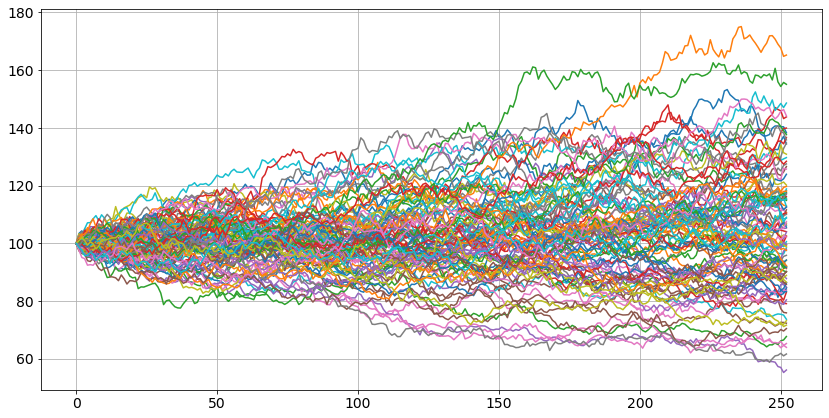

In [3]:
# Simulation of 1000 possible price paths

S=pricepath(100,1,0.05,0.2,1000)
plt.plot(S[:,:100])
plt.grid(True)
plt.show()

### Asion and Lookback option pricing

In [4]:
def option_val(s0,T,r,vol,N,strike):
    
    """
    This function prices the options through Monte Carlo method. 
    The options priced are Asian options with arithmetic and geometric averages and lookback options with fixed and floating strikes.
    All the options are priced both in call and put version. The Asian options are sampled continuously
    ______________

    Parameter:             Type:                Description:
    
    s0                     Float                Initial value of the stock
    T                      Integer              Time to expiry in years
    r                      Float                 Constant risk free interest rate
    vol                    Float                Volatility (standard deviation) of the GMB
    timesteps              Integer              Number of timesteps 
    N                      Integer              Number of desired iterations for the scheme
    strike                 Float                Strike price of the contract. This does not apply on floating strike lookbacks    
    
    """
    
    timesteps= int(np.around(T*252,0))
    
    S=pricepath(s0,T,r,vol,N)   # generate price paths with Euler-Maruyama scheme using the previously defined function
    Savg=np.zeros(timesteps)    # creating empty array
    
    for i in range(timesteps):  # averaging over all the simulations to get the average price path
        Savg[i]= np.mean(S[i,:]) 
    
    
    
    
    # OPTION PRICING (REMEMBER TO DISCOUNT)
    
    # ASIAN OPTION:
    
    # To price an Asian call/put, first compute the arithmetic and geometric average of all paths and their payoffs, 
    # then take the expectation value and discount
    
   
    Aritmavg=np.zeros(N)
    Geomavg=np.zeros(N)
    
    for i in range(N):              # Compute arithmetic and geometric average of all paths
        Aritmavg[i]=np.mean(S[:,i])
        Geomavg[i]=gmean(S[:,i])
    
    
    
    
    
    # CALL:
    Aritmpayoff_call=np.zeros(N)
    Geompayoff_call=np.zeros(N)
    
    for i in range(N):                                   # Compute calls payoffs of each path given the averages
        Aritmpayoff_call[i]=np.max([0,Aritmavg[i]-strike])
        Geompayoff_call[i]=np.max([0,Geomavg[i]-strike])
    
    #  -ARITHMETIC AVERAGE    
    V_asianartim_call=np.exp(-r*T)*np.mean(Aritmpayoff_call[:])  # Compute expected payoff and discounts
    
    #  -GEOMETRIC AVERAGE
    V_asiangeom_call=np.exp(-r*T)*np.mean(Geompayoff_call[:])    # Compute expected payoff and discounts
    
    # PUT:                                                   
    Aritmpayoff_put=np.zeros(N)
    Geompayoff_put=np.zeros(N)
    
    for i in range(N):                                   # Compute puts payoffs of each path given the averages
        Aritmpayoff_put[i]=np.max([0,strike-Aritmavg[i]])
        Geompayoff_put[i]=np.max([0,strike-Geomavg[i]])
    
    #  -ARITHMETIC AVERAGE
    V_asianartim_put=np.exp(-r*T)*np.mean(Aritmpayoff_put[:])
    
    #  -GEOMETRIC AVERAGE
    V_asiangeom_put=np.exp(-r*T)*np.mean(Geompayoff_put[:])
    
    
    
    # LOOKBACK OPTION:
    
    # To price a Lookback call/put, need to find the average max/min of the price path 
    # and the average final price for floating strike
    
    Max=np.zeros(N)
    Min=np.zeros(N)
    for i in range(N):
        Max[i]=np.max(S[:,i])
        Min[i]=np.min(S[:,i])    
       
        
    # CALL:
    
    Fixedpayoff_call=np.zeros(N)
    Floatpayoff_call=np.zeros(N)
    
    for i in range(N):                                   # Compute calls payoffs of each path given the averages
        Fixedpayoff_call[i]=np.max([0,Max[i]-strike])
        Floatpayoff_call[i]=np.max([0,S[-1,i]-Min[i]])
    
    #  -FIXED STRIKE
    V_lookfixed_call=np.exp(-r*T)*np.mean(Fixedpayoff_call[:])
    
    #  -FLOATING STRIKE
    V_lookfloating_call=np.exp(-r*T)*np.mean(Floatpayoff_call[:])
    
    # PUT:
    
    Fixedpayoff_put=np.zeros(N)
    Floatpayoff_put=np.zeros(N)
    
    for i in range(N):                                   # Compute puts payoffs of each path given the averages
        Fixedpayoff_put[i]=np.max([0,strike-Min[i]])
        Floatpayoff_put[i]=np.max([0,Max[i]-S[-1,i]])
    
    #  -FIXED STRIKE
    V_lookfixed_put=np.exp(-r*T)*np.mean(Fixedpayoff_put[:])
    
    #  -FLOATING STRIKE
    V_lookfloating_put=np.exp(-r*T)*np.mean(Floatpayoff_put[:])
    
    # Summarise results in a table
    results=np.around(np.array([V_asianartim_call,V_asiangeom_call,V_asianartim_put,V_asiangeom_put,V_lookfixed_call,V_lookfloating_call,V_lookfixed_put,V_lookfloating_put]),3)[:,np.newaxis] 
    
    options=["Arithmetic asian call","Geometric asian call","Arithmetic asian put","Geometric asian put","Fixed lookback call","Floating lookback call","Fixed lookback put","Floating lookback put"]
    
    table=pd.DataFrame(results,index=options,columns=["Option price:"])
    
    return table
    

### Results of option pricing for given exam parameters:

In [5]:
results_table=option_val(100,1,0.05,0.2,1000,100)
results_table

,Option price:
Arithmetic asian call,5.752
Geometric asian call,5.548
Arithmetic asian put,3.541
Geometric asian put,3.669
Fixed lookback call,17.987
Floating lookback call,15.755
Fixed lookback put,12.022
Floating lookback put,14.255


## Analysis on option pricing of the variaton of parameters 

In [6]:
# ANALYSIS OF INCREASING VOLATILITEIS

volatilities=np.linspace(0,1,21) # volatilities from 0% to 100%
lenght=len(volatilities)

aac=np.zeros(lenght)
gac=np.zeros(lenght)
aap=np.zeros(lenght)
gap=np.zeros(lenght)
fxlc=np.zeros(lenght)
fllc=np.zeros(lenght)
fxlp=np.zeros(lenght)
fllp=np.zeros(lenght)

for i in range(lenght):
    vol_res=option_val(100,1,0.05,volatilities[i],10000,100)
    aac[i]=vol_res.iloc[0,0]
    gac[i]=vol_res.iloc[1,0]
    aap[i]=vol_res.iloc[2,0]
    gap[i]=vol_res.iloc[3,0]
    fxlc[i]=vol_res.iloc[4,0]
    fllc[i]=vol_res.iloc[5,0]
    fxlp[i]=vol_res.iloc[6,0]
    fllp[i]=vol_res.iloc[7,0]

In [7]:
vol_table=pd.DataFrame(np.array([aac,gac,aap,gap,fxlc,fllc,fxlp,fllp]),index=vol_res.index,columns=volatilities)
vol_table

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
Arithmetic asian call,2.418,2.680,3.589,4.615,5.675,6.747,7.823,8.901,9.979,11.055,...,13.202,14.272,15.339,16.404,17.467,18.526,19.579,20.628,21.673,22.715
Geometric asian call,2.408,2.653,3.520,4.483,5.459,6.425,7.374,8.303,9.209,10.093,...,11.785,12.596,13.381,14.140,14.873,15.577,16.254,16.905,17.527,18.123
Arithmetic asian put,0.000,0.314,1.273,2.349,3.457,4.575,5.697,6.818,7.937,9.054,...,11.276,12.380,13.480,14.576,15.667,16.752,17.830,18.900,19.965,21.023
Geometric asian put,0.000,0.317,1.296,2.411,3.577,4.773,5.991,7.226,8.478,9.744,...,12.313,13.617,14.931,16.255,17.586,18.924,20.266,21.616,22.969,24.327
Fixed lookback call,4.877,6.777,10.328,14.186,18.209,22.369,26.662,31.084,35.632,40.308,...,50.048,55.119,60.327,65.674,71.163,76.798,82.583,88.519,94.608,100.851
Floating lookback call,4.877,6.703,9.958,13.303,16.598,19.812,22.940,25.979,28.931,31.796,...,37.282,39.907,42.459,44.940,47.353,49.705,51.999,54.236,56.423,58.564
Fixed lookback put,0.000,1.874,5.174,8.560,11.891,15.138,18.292,21.352,24.317,27.188,...,32.657,35.258,37.772,40.201,42.547,44.813,47.001,49.111,51.146,53.108
Floating lookback put,0.000,1.948,5.543,9.442,13.502,17.695,22.014,26.456,31.019,35.700,...,45.423,50.469,55.640,60.936,66.357,71.907,77.586,83.394,89.330,95.394


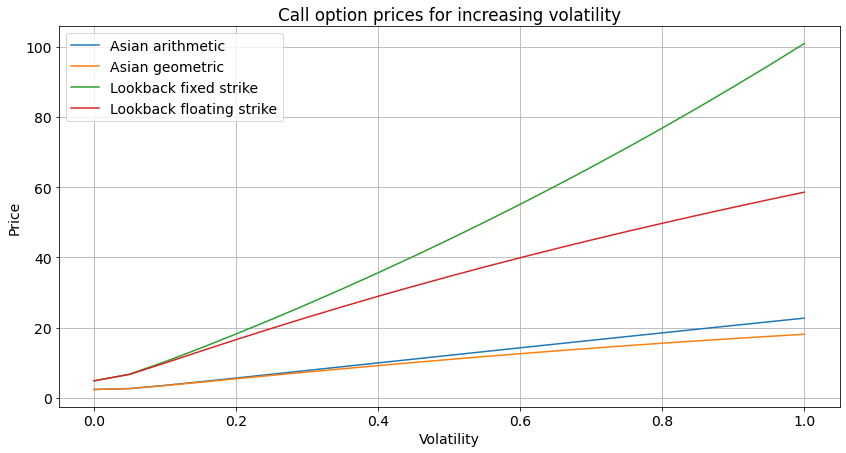

In [8]:
plt.plot(volatilities,aac,label="Asian arithmetic")
plt.plot(volatilities,gac,label="Asian geometric")
plt.plot(volatilities,fxlc,label="Lookback fixed strike")
plt.plot(volatilities,fllc,label="Lookback floating strike")
plt.title("Call option prices for increasing volatility")
plt.xlabel("Volatility")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

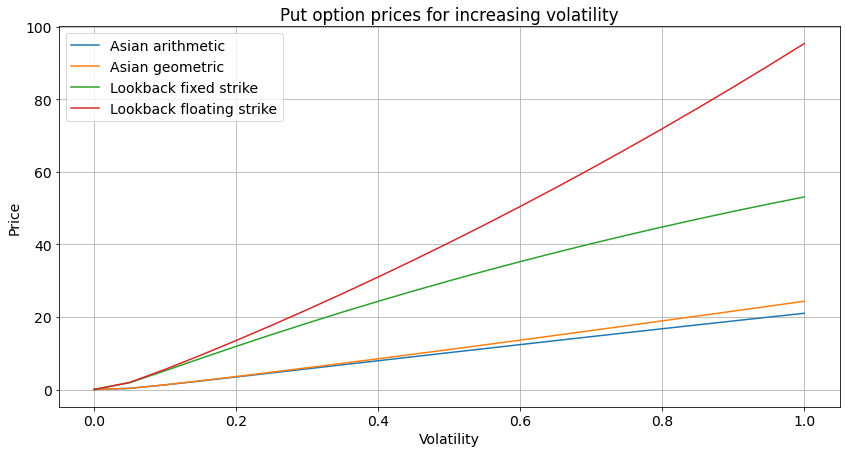

In [9]:
plt.plot(volatilities,aap,label="Asian arithmetic")
plt.plot(volatilities,gap,label="Asian geometric")
plt.plot(volatilities,fxlp,label="Lookback fixed strike")
plt.plot(volatilities,fllp,label="Lookback floating strike")
plt.title("Put option prices for increasing volatility")
plt.xlabel("Volatility")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# TIME TO EXPIRY ANALYSIS

Time_expiry=np.linspace(0.1,2,21)    # time to expiry from about a month to two years
lenght=len(Time_expiry)

aac=np.zeros(lenght)
gac=np.zeros(lenght)
aap=np.zeros(lenght)
gap=np.zeros(lenght)
fxlc=np.zeros(lenght)
fllc=np.zeros(lenght)
fxlp=np.zeros(lenght)
fllp=np.zeros(lenght)

for i in range(lenght):
    T_res=option_val(100,Time_expiry[i],0.05,0.2,10000,100)
    aac[i]=T_res.iloc[0,0]
    gac[i]=T_res.iloc[1,0]
    aap[i]=T_res.iloc[2,0]
    gap[i]=T_res.iloc[3,0]
    fxlc[i]=T_res.iloc[4,0]
    fllc[i]=T_res.iloc[5,0]
    fxlp[i]=T_res.iloc[6,0]
    fllp[i]=T_res.iloc[7,0]

In [11]:
Time_table=pd.DataFrame(np.array([aac,gac,aap,gap,fxlc,fllc,fxlp,fllp]),index=T_res.index,columns=np.around(Time_expiry,3))
Time_table

,0.100,0.195,0.290,0.385,0.480,0.575,0.670,0.765,0.860,0.955,...,1.145,1.240,1.335,1.430,1.525,1.620,1.715,1.810,1.905,2.000
Arithmetic asian call,1.533,2.211,2.767,3.244,3.677,4.081,4.466,4.832,5.180,5.520,...,6.160,6.463,6.753,7.035,7.309,7.576,7.837,8.096,8.350,8.598
Geometric asian call,1.514,2.175,2.711,3.169,3.583,3.966,4.329,4.674,4.999,5.315,...,5.907,6.186,6.453,6.712,6.963,7.206,7.443,7.677,7.905,8.128
Arithmetic asian put,1.309,1.829,2.191,2.456,2.675,2.865,3.030,3.175,3.296,3.407,...,3.598,3.676,3.748,3.814,3.876,3.933,3.986,4.036,4.083,4.126
Geometric asian put,1.325,1.859,2.234,2.511,2.740,2.941,3.117,3.272,3.404,3.524,...,3.731,3.818,3.898,3.973,4.043,4.108,4.168,4.225,4.279,4.329
Fixed lookback call,4.628,6.856,8.679,10.246,11.665,13.007,14.288,15.488,16.627,17.719,...,19.769,20.726,21.636,22.540,23.409,24.265,25.136,25.998,26.799,27.599
Floating lookback call,4.453,6.554,8.211,9.694,10.907,12.092,13.237,14.230,15.274,16.137,...,17.947,18.680,19.418,20.142,20.857,21.462,22.255,22.881,23.590,24.184
Fixed lookback put,4.063,5.811,7.028,7.985,8.811,9.546,10.177,10.733,11.252,11.693,...,12.486,12.832,13.158,13.476,13.750,14.014,14.263,14.510,14.736,14.944
Floating lookback put,4.238,6.113,7.495,8.537,9.569,10.460,11.227,11.992,12.604,13.274,...,14.309,14.878,15.376,15.874,16.302,16.817,17.144,17.628,17.945,18.359


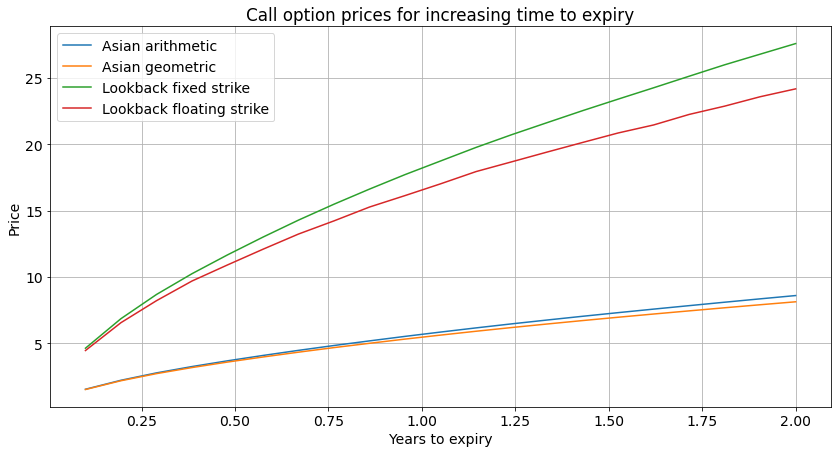

In [12]:
plt.plot(Time_expiry,aac,label="Asian arithmetic")
plt.plot(Time_expiry,gac,label="Asian geometric")
plt.plot(Time_expiry,fxlc,label="Lookback fixed strike")
plt.plot(Time_expiry,fllc,label="Lookback floating strike")
plt.title("Call option prices for increasing time to expiry")
plt.xlabel("Years to expiry")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

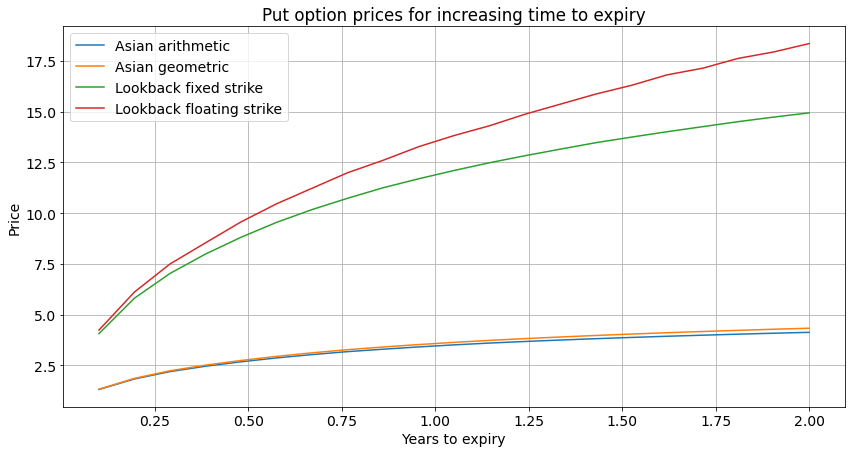

In [13]:
plt.plot(Time_expiry,aap,label="Asian arithmetic")
plt.plot(Time_expiry,gap,label="Asian geometric")
plt.plot(Time_expiry,fxlp,label="Lookback fixed strike")
plt.plot(Time_expiry,fllp,label="Lookback floating strike")
plt.title("Put option prices for increasing time to expiry")
plt.xlabel("Years to expiry")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# ANALYSIS OF INCREASING RISK FREE RATES

riskfreerate=np.linspace(-1,1)    # risk free rates between -100% and 100%
lenght=len(riskfreerate)

aac=np.zeros(lenght)
gac=np.zeros(lenght)
aap=np.zeros(lenght)
gap=np.zeros(lenght)
fxlc=np.zeros(lenght)
fllc=np.zeros(lenght)
fxlp=np.zeros(lenght)
fllp=np.zeros(lenght)

for i in range(lenght):
    risk_res=option_val(100,1,riskfreerate[i],0.2,10000,100)
    aac[i]=risk_res.iloc[0,0]
    gac[i]=risk_res.iloc[1,0]
    aap[i]=risk_res.iloc[2,0]
    gap[i]=risk_res.iloc[3,0]
    fxlc[i]=risk_res.iloc[4,0]
    fllc[i]=risk_res.iloc[5,0]
    fxlp[i]=risk_res.iloc[6,0]
    fllp[i]=risk_res.iloc[7,0]

In [15]:
risk_table=pd.DataFrame(np.array([aac,gac,aap,gap,fxlc,fllc,fxlp,fllp]),index=risk_res.index,columns=np.around(riskfreerate,3))
risk_table

,-1.000,-0.959,-0.918,-0.878,-0.837,-0.796,-0.755,-0.714,-0.673,-0.633,...,0.633,0.673,0.714,0.755,0.796,0.837,0.878,0.918,0.959,1.000
Arithmetic asian call,0.000,0.000,0.000,0.000,0.001,0.001,0.002,0.004,0.007,0.015,...,20.816,21.600,22.335,23.021,23.661,24.257,24.811,25.325,25.800,26.240
Geometric asian call,0.000,0.000,0.000,0.000,0.001,0.001,0.002,0.004,0.007,0.013,...,19.351,20.005,20.605,21.152,21.650,22.102,22.508,22.872,23.195,23.480
Arithmetic asian put,100.422,93.558,87.013,80.775,74.829,69.163,63.765,58.625,53.731,49.076,...,0.007,0.004,0.002,0.001,0.001,0.000,0.000,0.000,0.000,0.000
Geometric asian put,108.014,100.439,93.233,86.379,79.864,73.671,67.787,62.199,56.895,51.863,...,0.007,0.004,0.003,0.001,0.001,0.000,0.000,0.000,0.000,0.000
Fixed lookback call,3.632,3.693,3.762,3.840,3.928,4.030,4.145,4.276,4.425,4.595,...,49.068,50.999,52.863,54.663,56.399,58.073,59.686,61.237,62.730,64.167
Floating lookback call,1.374,1.456,1.546,1.644,1.752,1.873,2.009,2.160,2.328,2.515,...,47.975,49.938,51.837,53.669,55.437,57.141,58.782,60.363,61.884,63.347
Fixed lookback put,173.571,162.765,152.403,142.467,132.943,123.816,115.075,106.704,98.691,91.025,...,1.341,1.191,1.061,0.947,0.848,0.760,0.683,0.616,0.555,0.502
Floating lookback put,175.829,165.003,154.620,144.663,135.119,125.974,117.212,108.820,100.788,93.104,...,2.435,2.252,2.088,1.941,1.811,1.693,1.587,1.490,1.402,1.322


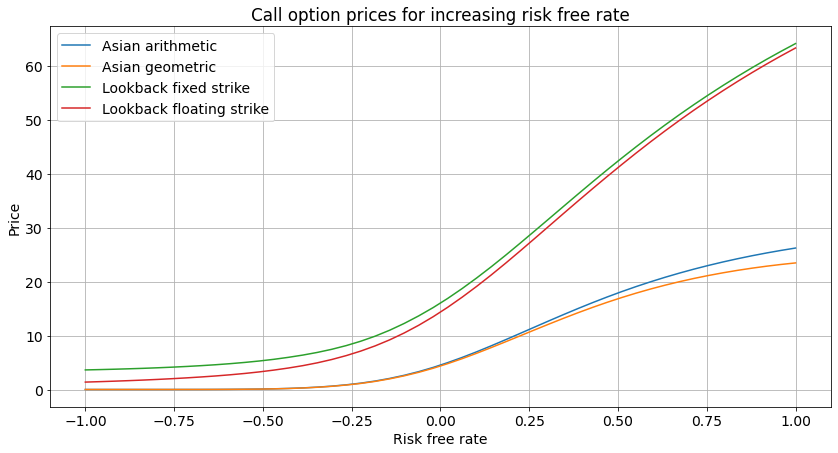

In [16]:
plt.plot(riskfreerate,aac,label="Asian arithmetic")
plt.plot(riskfreerate,gac,label="Asian geometric")
plt.plot(riskfreerate,fxlc,label="Lookback fixed strike")
plt.plot(riskfreerate,fllc,label="Lookback floating strike")
plt.title("Call option prices for increasing risk free rate")
plt.xlabel("Risk free rate")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

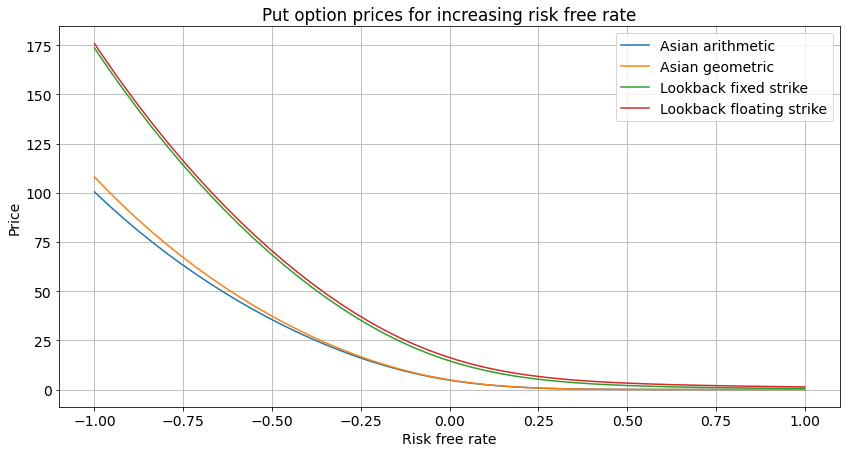

In [17]:
plt.plot(riskfreerate,aap,label="Asian arithmetic")
plt.plot(riskfreerate,gap,label="Asian geometric")
plt.plot(riskfreerate,fxlp,label="Lookback fixed strike")
plt.plot(riskfreerate,fllp,label="Lookback floating strike")
plt.title("Put option prices for increasing risk free rate")
plt.xlabel("Risk free rate")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
# ANALYSIS OF INCREASING STRIKE PRICES
strike=np.linspace(0,300,301)    # strike prices from 0 to 150
lenght=len(strike)

aac=np.zeros(lenght)
gac=np.zeros(lenght)
aap=np.zeros(lenght)
gap=np.zeros(lenght)
fxlc=np.zeros(lenght)
fllc=np.zeros(lenght)
fxlp=np.zeros(lenght)
fllp=np.zeros(lenght)

for i in range(lenght):
    strike_res=option_val(100,1,0.05,0.2,1000,strike[i])
    aac[i]=strike_res.iloc[0,0]
    gac[i]=strike_res.iloc[1,0]
    aap[i]=strike_res.iloc[2,0]
    gap[i]=strike_res.iloc[3,0]
    fxlc[i]=strike_res.iloc[4,0]
    fllc[i]=strike_res.iloc[5,0]
    fxlp[i]=strike_res.iloc[6,0]
    fllp[i]=strike_res.iloc[7,0]

In [19]:
strike_table=pd.DataFrame(np.array([aac,gac,aap,gap,fxlc,fllc,fxlp,fllp]),index=strike_res.index,columns=strike)
strike_table

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,291.0,292.0,293.0,294.0,295.0,296.0,297.0,298.0,299.0,300.0
Arithmetic asian call,97.335,96.383,95.432,94.481,93.530,92.578,91.627,90.676,89.725,88.774,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Geometric asian call,97.002,96.051,95.100,94.149,93.198,92.246,91.295,90.344,89.393,88.441,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Arithmetic asian put,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,179.473,180.424,181.376,182.327,183.278,184.229,185.181,186.132,187.083,188.034
Geometric asian put,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,179.805,180.757,181.708,182.659,183.610,184.561,185.513,186.464,187.415,188.366
Fixed lookback call,113.110,112.159,111.208,110.256,109.305,108.354,107.403,106.451,105.500,104.549,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Floating lookback call,15.755,15.755,15.755,15.755,15.755,15.755,15.755,15.755,15.755,15.755,...,15.755,15.755,15.755,15.755,15.755,15.755,15.755,15.755,15.755,15.755
Fixed lookback put,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,193.707,194.658,195.610,196.561,197.512,198.463,199.415,200.366,201.317,202.268
Floating lookback put,14.255,14.255,14.255,14.255,14.255,14.255,14.255,14.255,14.255,14.255,...,14.255,14.255,14.255,14.255,14.255,14.255,14.255,14.255,14.255,14.255


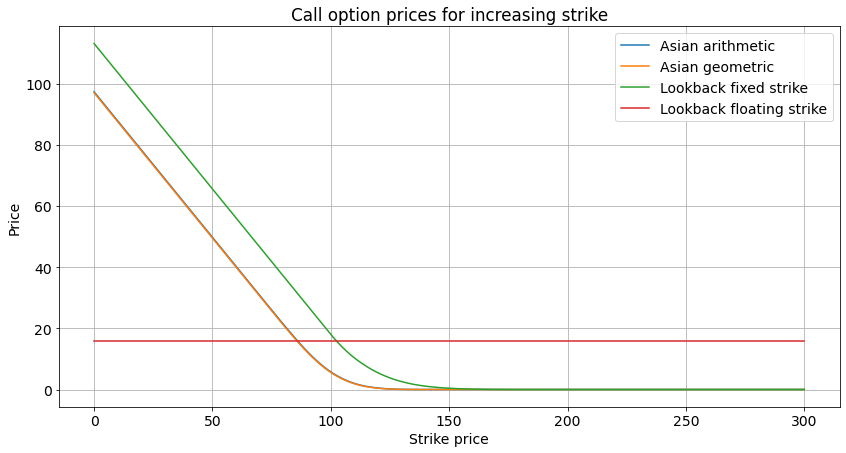

In [20]:
plt.plot(strike,aac,label="Asian arithmetic")
plt.plot(strike,gac,label="Asian geometric")
plt.plot(strike,fxlc,label="Lookback fixed strike")
plt.plot(strike,fllc,label="Lookback floating strike")
plt.title("Call option prices for increasing strike")
plt.xlabel("Strike price")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

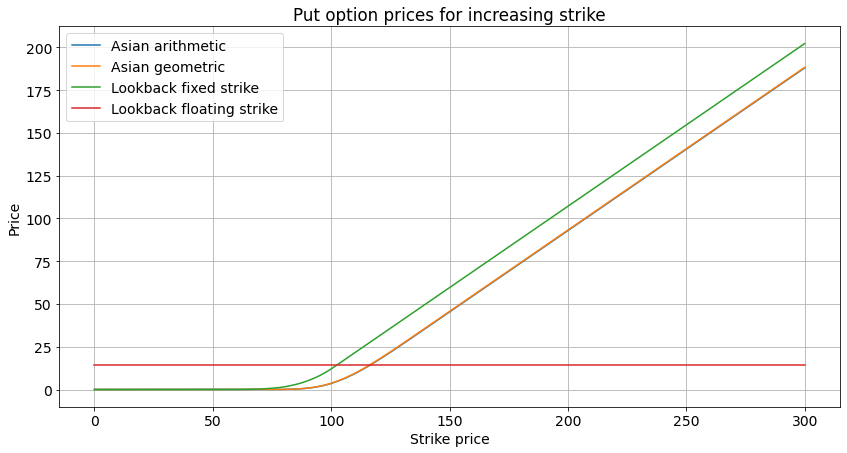

In [21]:
plt.plot(strike,aap,label="Asian arithmetic")
plt.plot(strike,gap,label="Asian geometric")
plt.plot(strike,fxlp,label="Lookback fixed strike")
plt.plot(strike,fllp,label="Lookback floating strike")
plt.title("Put option prices for increasing strike")
plt.xlabel("Strike price")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

# Results, analysis and points of interest

Here I present and analyse the results of the parameters variation for the different option types:

## Increasing volatility:
As the volatility ranges from 0 to 100%, we notice that all the options prices increase approximatively linearly, regardless of them being calls or puts, but the lookback options have a steeper increase. This can be explained by the fact that lookback options rely on price maxima/minima, and higher volatility leads to a higher payoff. Asian options are instead dependent on averages, which dampens the effects of volatility.\
An interesting observation to point out is that when the volatility vanishes ($\sigma=0$), the put options are valued 0 while the Asian call options are valued approximatively 2.5£ and the lookback 5£. The explanation of this can be found in the risk-free rate. Given that with no volatility the price paths lose their stochastic element, the final price will be an artefact of the drift. Having a positive drift of 0.05 and an initial price of 100£, we see that the final price of the underlying will be 105£. This means exactly a discounted 5£ payoff for a call relying on the maximum price achieved (the Lookbacks) and a discounted 2.5£ payoff for a call relying on the average price (the Asians), while the puts all have 0 payoffs.\
Lastly, we can see that fixed strike lookbacks call are more valuable than floating strike call, while the opposite happens for puts. The reason for this behaviour can still be found in the positive drift of the underlying given by the risk-free rate.\
Since the average final price is about 105£ due to the risk-free rate, a fixed strike call is more valuable as it picks the maximum price which is given by a random jump upwards of the price due to the stochastic term. This is added to an average increase of the price upwards. On the other hand, a floating strike call compares the minimum price reached to the final price of the underlying, which requires a bigger stochastic jump of the underlying against its drift to have the same payoff of a fixed strike call. The opposite situation is realised for call options.

## Increasing time to expiry:
As the time to expiry increases, all options become more valuable.
For Asian options, this can be explained by the fact that the initial underlying value and the strike price are the same. As the time to expiry grows, there is more time for the underlying price to average up or down, while for Lookback options the probability of a favourable stochastic movement of the underlying before the expiry date increases the further we are from it.\
Moreover, for Asian options, the value increase tends to plateau, while for lookbacks the price has more of a linear growth.

## Increasing risk-free rate:
When analysing a changing risk-free rate, the range of analysed rates was taken to be  $r\in (-1,1)$. Negative risk-free rates are possible and refer to a situation in which people are willing to pay for safety.\
As the risk-free rate increase, call options become more valuable and put options become less valuable. This is easy to interpret as the risk-free rate represents the drift of the underlying. The higher the drift, the greater the underlying price at the expiry time, the bigger the payoffs on calls and smaller on puts.\
What is interesting to notice is that in this scenario we do not have a sizeable divergence between fixed and floating Lookbacks, and between arithmetic and geometric Asians. This is a sign that a change in the risk-free rate affects the class of options (Lookbacks or Asians) more than the specific kind of option subclass (floating-fixed, arithmetic-geometric).\
Finally, it is important to mention how the price of Asian calls/puts drops to 0 at a certain value of the interest rate, while the values of lookbacks do not. This is insightful as we see how Lookback options rely more on volatility with respect to Asian options. When considering an Asian call, for example, as the interest rate drops to 0 it will still have a non-zero price due to the presence of volatility which could produce an average positive price above the strike. As the rate becomes negative, there will be a value in which the fluctuations will not be enough to compensate the drift which will push the average price below the strike, making the option out of the money. This point is dependent on the system volatility and will move towards zero risk-free rates as the volatility value drops.
This, instead, does not happen with lookback options, that never reach the point of being out of the money.\

## Increasing strike price
As the strike price set in the option contract increases from 0 to 150£, we see call options become less valuable while put options appreciate. This is easy to interpret as it is a fundamental property of call and put options, the more the strike price increases, the higher the chances that a call option will be out of the money and a put option will be in the money.\
The interesting point to notice is that floating strike Lookbacks are not affected by the change. The reason lies in the unique way in which the strike for a floating lookback option is set. Indeed, for this particular subclass of options, the strike price depends on the most favourable value taken by the underlying and it is not set when the option is written. This is the reason why this variable does not affect the option value, it is not a part of it.\

### A note on the initial underlying price $S_0$
The starting price of the underlying, denoted usually as  $S_0$,is a parameter necessary for the option pricing algorithm. regardless of this, an analysis of the behaviour of the option prices as the starting underlying price varies has not been done. \
The reason is that the analysis of the strike price variation includes the analysis of the variation of the initial underlying value because the real parameter that matters in the option pricing is the difference between the two and not their value. Therefore, studying a range of strike prices between 0 and 150£ with a strike price of 100£ should be interpreted as studying a range of differences between the starting underlying price and the strike price going from -150£ to +150£.

# Conclusions and references:

Options are fascinating contracts that allow for a wide variety of financial strategies to be applied. Asians and Lookbacks options were analysed here, with Asian options split into arithmetic and geometric average and Lookbacks split into fixed and floating strikes.
Given a set of parameters, a Monte Carlo simulation using the Euler-Maruyama scheme was utilised to simulate the underlying asset price paths. The payoff for each path was computed for all the option types mentioned and the results were then averaged and discounted to find the estimated option price.\
Following the option pricing, an analysis has been done by varying the parameters of volatility, risk-free rate, time to expiry and strike price. The way in which the option price varies with these variables has been studied, leading to insights into the behaviour and dependence of different classes and subclasses of Asian and Lookback options on these parameters.

## References:
Lecture notes on Exotic Options - Paul Willmott, CQF \
Asian Option - James Chen - Investopedia: https://www.investopedia.com/terms/a/asianoption.asp \
Lookback Option - Gordon Scott - Investopedia: https://www.investopedia.com/terms/l/lookbackoption.asp